## Regression Models for First Race Record

In [1]:
# Repetitive cell from regression_models.ipynb
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys
import seaborn as sns
module_path = '{}\\'.format(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))
sys.path.append(module_path)

from analysis.predictive.settings import TIME_WINDOW
from feature_engineering import feature_engineer, drop_cols
from grid_search import get_best_model
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from model_comparer import ModelComparer
from process_pred import get_pred_values, store_values
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from stack_model_comparer import StackModelComparer
from xgboost import XGBRegressor

%matplotlib inline

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# Read data from the data folder
file_directory = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')) + '\\'
sample = False
sample_size = 10000

# Window size for moving averages
max_window = TIME_WINDOW

try:
    # Read data from directory and format date value
    df_combined = pd.read_csv(file_directory + 'data/processed/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    # Sample the dataframe if specified
    if sample:
        df_combined = df_combined.sort_values('run_date').iloc[:sample_size]
        
    # Set multi-index
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)

    # Read data from those with first occurrence and drop some columns
    first_occur_df = pd.read_csv(file_directory + 'data/processed/first_occurrence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    drop_cols(first_occur_df)
    first_occur_df.sort_values(['horse_id', 'run_date'], inplace=True)
    first_occur_df.set_index(['horse_id', 'run_date'], inplace=True)
    
    # Filter current dataframe by removing those without prior time information
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.index)]
except FileNotFoundError:
    # Do some data transformation if file is not found
    horse_race_df = pd.read_csv(file_directory + 'data/processed/horse_race.csv', low_memory=False, index_col=0)
    horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)
    horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
    horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
    drop_cols(horse_race_df)
    
    # Do dependent variable feature engineering
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']
    
    # Cast dataframe to primitive types and iteratively visit to get mean and median value
    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)
    
    # Get moving average and exponential moving average values
    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
        
    # Output data files
    df_combined.reset_index().to_csv('data/processed/horse_race_combined.csv', encoding='utf-8')

In [3]:
# Visualize dependent variable columns
dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]

# Separate X and y dataframe
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()

# Initiate mapping dict
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']

for col_name in dependent[3:]:
    # Do some mapping for modelling use
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)
    
# Get an overview of data
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

## Baseline Regression Models

In [4]:
first_occur_df_X = first_occur_df.drop('run_time_1000', axis=1)
first_occur_df_y = first_occur_df['run_time_1000']
mc = ModelComparer(first_occur_df_X, pd.DataFrame(first_occur_df_y), df_y_original_dict, df_name='first_race_featured')

Split training and testing set by date range with 0.85 ratio:
Training set date range: 2000-01-08 10:00:00 -> 2014-06-22 10:10:00
Testing set date range: 2014-06-22 12:10:00 -> 2018-02-18 15:40:00


In [5]:
# Add base model
mc.add_model(LinearRegression, model_name='OLS', fit_intercept=True)
mc.add_model(XGBRegressor, 'XGB', learning_rate=0.1)
mc.add_model(DecisionTreeRegressor, 'DT', max_depth=6)
mc.add_model(RandomForestRegressor, 'RF', max_depth=6, n_estimators=20)
mc.add_model(GradientBoostingRegressor, 'GBM', 
             n_estimators=100, max_depth=6, min_samples_split=2, learning_rate=0.1)

# Add ANN with verbose as True
mc.add_model(MLPRegressor, 'ANN', max_iter=100000, learning_rate_init=0.001, hidden_layer_sizes=(150,), activation='tanh')

[>]: Performing analysis on column run_time_1000 for model OLS (Size: (57690, 214))
Added model named OLS 
[>]: Performing analysis on column run_time_1000 for model XGB (Size: (57690, 214))
Added model named XGB 
[>]: Performing analysis on column run_time_1000 for model DT (Size: (57690, 214))
Added model named DT 
[>]: Performing analysis on column run_time_1000 for model RF (Size: (57690, 214))
Added model named RF 
[>]: Performing analysis on column run_time_1000 for model GBM (Size: (57690, 214))
Added model named GBM 
[>]: Performing analysis on column run_time_1000 for model ANN (Size: (57690, 214))
Added model named ANN 


In [6]:
mc.get_report(filter_word='RMSE')

,ANN,DT,GBM,OLS,RF,XGB
Original RMSE: run_time_1000 (57690),2.294426,2.265143,2.351309,2.276789,2.264031,2.264248


In [7]:
mc.add_model(XGBRegressor, 'XGB - Tuned', 
             learning_rate=0.1, colsample_bytree=0.8, gamma=0.3, max_depth=3, 
             min_child_weight=7, reg_alpha=0.01, subsample=0.6)
mc.add_model(RandomForestRegressor, 'RF - Tuned', 
             max_depth=8, n_estimators=40, max_features='sqrt')
mc.add_model(GradientBoostingRegressor, 'GBM - Tuned', 
             n_estimators=100, max_depth=5, max_features=20, min_samples_leaf=50, 
             min_samples_split=500, subsample=0.8, learning_rate=0.1)

[>]: Performing analysis on column run_time_1000 for model XGB - Tuned (Size: (57690, 214))
Added model named XGB - Tuned 
[>]: Performing analysis on column run_time_1000 for model RF - Tuned (Size: (57690, 214))
Added model named RF - Tuned 
[>]: Performing analysis on column run_time_1000 for model GBM - Tuned (Size: (57690, 214))
Added model named GBM - Tuned 


In [8]:
mc.get_report(filter_word='RMSE')

,ANN,DT,GBM,GBM - Tuned,OLS,RF,RF - Tuned,XGB,XGB - Tuned
Original RMSE: run_time_1000 (57690),2.294426,2.265143,2.351309,2.269225,2.276789,2.264031,2.259724,2.264248,2.266978


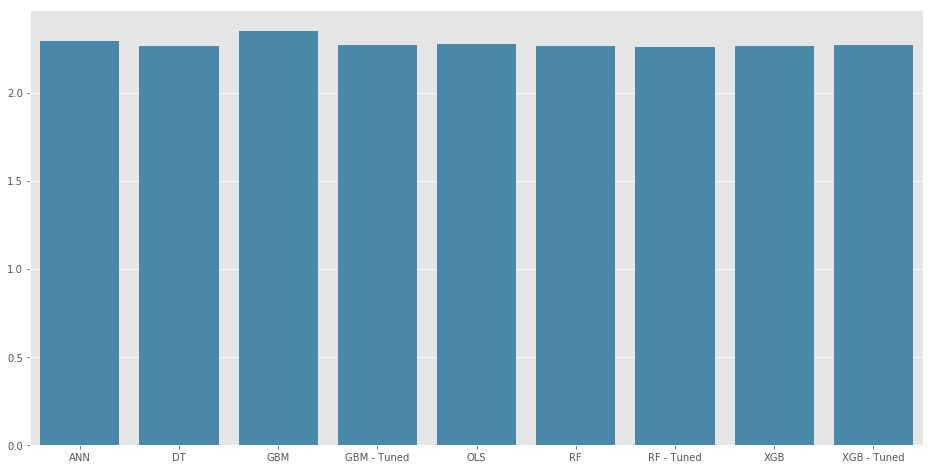

In [9]:
# Set some specs for plotting
report = mc.get_report(filter_word='RMSE')
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.barplot(data=report, color='#3A8FB7')